In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import datetime as dt
from datetime import timedelta
import matplotlib.ticker as mticker
import plotly.express as px
%matplotlib inline

In [2]:
All = pd.read_csv('./data/All_Ads.csv')
Aired = pd.read_csv('./data/All_Aired_Ads.csv')

### Dataset Overview

- The "All" dataset comprises one unique ad as an observation.
- The "Aired" dataset has observations which are each airing of an ad.

These datasets share one key variable: 'wp_identifier'. Merging these datasets allows us to gain information without losing track of a specific ad.

##### Note: Data during the 2016 primary months were broadcasted to 20 markets. Data during the general elections were broadcasted to only 10 markets. Their respective markets can be found from the archive here: **http://politicaladarchive.org/data/**

In [3]:
data = pd.merge(Aired, All)
data.head()

,id,wp_identifier,network,location,program,program_type,start_time,end_time,archive_id,embed_url,...,subjects,candidates,type,message,date_created,air_count,reference_count,market_count,transcript,date_ingested
0,1,5643,KLAS,"Las Vegas, NV",8 News Now at 5 PM,news,2016-09-09 00:12:59 UTC,2016-09-09 00:13:29 UTC,PolAd_HillaryClinton_f1h3j,https://archive.org/embed/PolAd_HillaryClinton...,...,"Energy, China, Jobs",Hillary Clinton,campaign,pro,9/12/2016 14:49,1916,0,6,IThere's a race going on right approve tnow.me...,2016/09/12 2:12:03 UTC
1,2,5643,WNCN,"Raleigh-Durham-Fayetteville, NC",North Carolina News at 500PM,news,2016-09-06 21:58:25 UTC,2016-09-06 21:58:55 UTC,PolAd_HillaryClinton_f1h3j,https://archive.org/embed/PolAd_HillaryClinton...,...,"Energy, China, Jobs",Hillary Clinton,campaign,pro,9/12/2016 14:49,1916,0,6,IThere's a race going on right approve tnow.me...,2016/09/12 2:12:03 UTC
2,3,5643,KLAS,"Las Vegas, NV",Face the Nation,news,2016-09-04 16:24:25 UTC,2016-09-04 16:24:55 UTC,PolAd_HillaryClinton_f1h3j,https://archive.org/embed/PolAd_HillaryClinton...,...,"Energy, China, Jobs",Hillary Clinton,campaign,pro,9/12/2016 14:49,1916,0,6,IThere's a race going on right approve tnow.me...,2016/09/12 2:12:03 UTC
3,4,5643,WFLA,"Tampa-St. Petersburg, FL",Days of Our Lives,not news,2016-08-30 17:59:20 UTC,2016-08-30 17:59:50 UTC,PolAd_HillaryClinton_f1h3j,https://archive.org/embed/PolAd_HillaryClinton...,...,"Energy, China, Jobs",Hillary Clinton,campaign,pro,9/12/2016 14:49,1916,0,6,IThere's a race going on right approve tnow.me...,2016/09/12 2:12:03 UTC
4,5,5643,KSNV,"Las Vegas, NV",The Tonight Show Starring Jimmy Fallon,news,2016-09-06 07:02:22 UTC,2016-09-06 07:02:52 UTC,PolAd_HillaryClinton_f1h3j,https://archive.org/embed/PolAd_HillaryClinton...,...,"Energy, China, Jobs",Hillary Clinton,campaign,pro,9/12/2016 14:49,1916,0,6,IThere's a race going on right approve tnow.me...,2016/09/12 2:12:03 UTC


In [4]:
#Dropping unnecessary variables

data = data.drop(columns = ['id', 'archive_id', 'embed_url', 'transcript', 'date_ingested', 'date_created'])

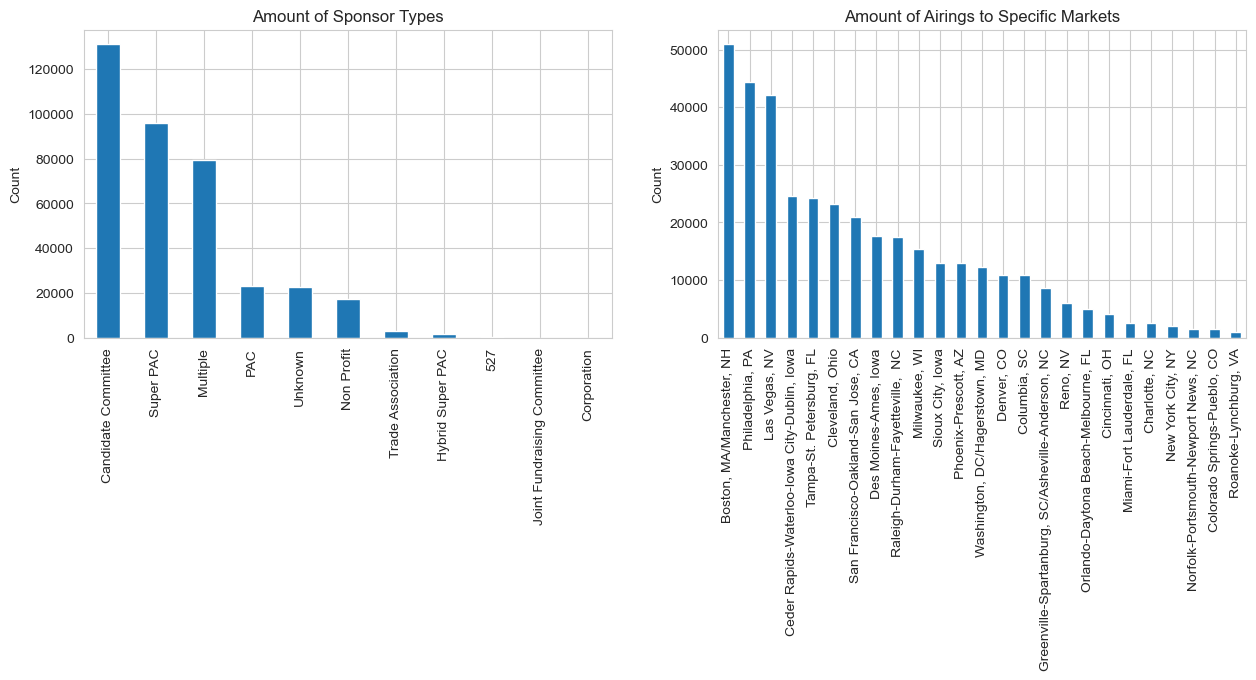

In [5]:
#Initial plots
f = plt.figure(figsize= (15, 4))
gs = f.add_gridspec(1, 2)


with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    data['sponsor_types'].value_counts().plot(kind = 'bar')
    ax.set_ylabel('Count')
    plt.title('Amount of Sponsor Types')

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    data['location'].value_counts().plot(kind = 'bar')
    ax.set_ylabel('Count')
    plt.title('Amount of Airings to Specific Markets')

In [6]:
#Time variables are not in datetime format

data.dtypes

wp_identifier        int64
network             object
location            object
program             object
program_type        object
start_time          object
end_time            object
sponsors            object
sponsor_types       object
race                object
cycle              float64
subjects            object
candidates          object
type                object
message             object
air_count            int64
reference_count      int64
market_count         int64
dtype: object

# Data cleaning and formatting

In [7]:
#For some reason, there is 'mixed' and 'mix' as a values in the 'message' column. Thus, I will convert all 'mix' values to 'mixed'.

data['message'] = np.where(data['message'] == 'mix', 'mixed', data['message'])

In [8]:
#Creating a variable by formatting the 'start_time' and 'end_time' variable which tells what specific day an ad aired

data['start_time_day'] = pd.to_datetime(data['start_time'].str[:10], format = '%Y-%m-%d')

#Formatting 'start_time' and 'end_time' to datetime objects

data['start_time'] = pd.to_datetime(data['start_time'].str[:19], format = '%Y-%m-%d %H:%M:%S')
data['end_time'] = pd.to_datetime(data['end_time'].str[:19], format = '%Y-%m-%d %H:%M:%S')

In [9]:
data[['start_time', 'start_time_day', 'end_time']].dtypes

start_time        datetime64[ns]
start_time_day    datetime64[ns]
end_time          datetime64[ns]
dtype: object

In [10]:
#'Donald J Trump For President' seems to be a typo for 'Donald J. Trump for President'. Fixing the typo here

data['sponsors'] = np.where(data['sponsors'] == 'Donald J Trump For President', 'Donald J. Trump For President', data['sponsors'])

In [11]:
#Creating new variable so that our plot will only categorize the most popular candidates

data['popular'] = np.where((data['candidates'] != 'Donald Trump') & (data['candidates'] != 'Hillary Clinton') & (data['candidates'] != 'Bernie Sanders'),'Other', data['candidates'])

#### Subsetting the data between the Primary and General elections.
With this, we can answer questions such as:
- Did more ads run during the general versus primary election?

In [12]:
Primary = data[(data['start_time_day'] < '2016-06-14') & (data['start_time_day'] > '2016-02-01')]
General = data[(data['start_time_day'] > '2016-06-14') | (data['start_time_day'] < '2016-02-01')]

# Were there any ads that overlapped between the Primary and General Election months?

Primary['wp_identifier'].isin(General['wp_identifier']).value_counts()

#Maybe do some analysis for ads that did show up during Primary and G.E. months?

False    54761
True     34203
Name: wp_identifier, dtype: int64

In [13]:
print('Ads that ran during Primary Months\n')
print(Primary[['wp_identifier', 'air_count']].groupby(['wp_identifier']).count().sort_values(by = 'air_count', ascending= False).head())

print('Ads that ran during General Election\n')
print(General[['wp_identifier', 'air_count']].groupby(['wp_identifier']).count().sort_values(by = 'air_count', ascending= False).head())

Ads that ran during Primary Months

               air_count
wp_identifier           
1056                3974
1928                3743
1364                2379
1257                2130
301                 2044
Ads that ran during General Election

               air_count
wp_identifier           
7349                3902
4685                3526
5183                3216
5025                3062
7933                2507


# Why did certain ads air more than others?

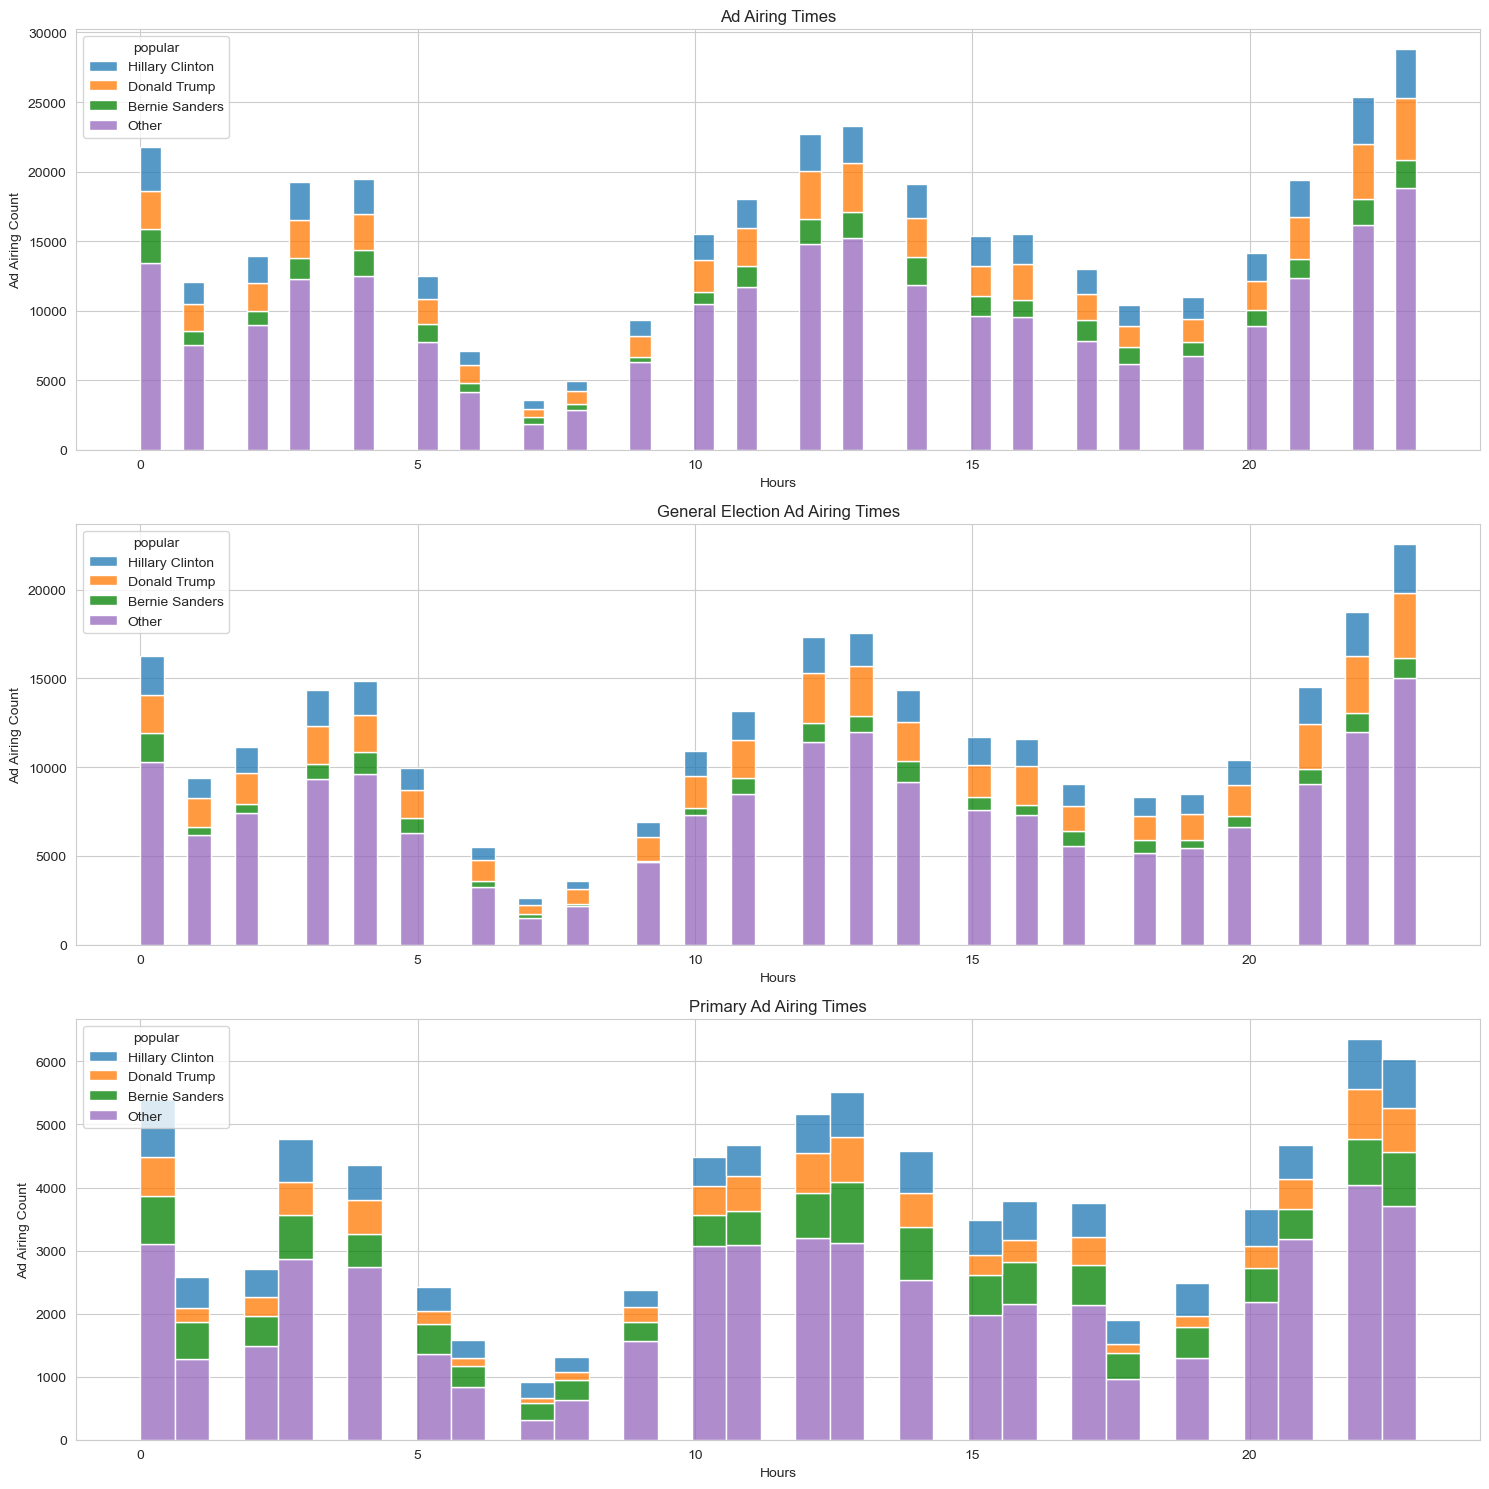

In [14]:
f = plt.figure(figsize= (15, 15))
gs = f.add_gridspec(3, 1)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.histplot(data = data, x = pd.DatetimeIndex(data['start_time']).hour, hue = 'popular', hue_order=['Hillary Clinton', 'Donald Trump', 'Bernie Sanders', 'Other'], multiple = 'stack', palette = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), '#ff7800', 'green' , (0.5803921568627451, 0.403921568627451, 0.7411764705882353)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_xlabel('Hours')
    plt.title('Ad Airing Times')

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.histplot(data = General, x = pd.DatetimeIndex(General['start_time']).hour, hue = 'popular', hue_order=['Hillary Clinton', 'Donald Trump', 'Bernie Sanders', 'Other'], multiple = 'stack', palette = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), '#ff7800', 'green' , (0.5803921568627451, 0.403921568627451, 0.7411764705882353)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_xlabel('Hours')
    plt.title('General Election Ad Airing Times')

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[2, 0])
    sns.histplot(data = Primary, x = pd.DatetimeIndex(Primary['start_time']).hour, hue = 'popular', hue_order=['Hillary Clinton', 'Donald Trump', 'Bernie Sanders', 'Other'], multiple = 'stack', palette = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), '#ff7800', 'green' , (0.5803921568627451, 0.403921568627451, 0.7411764705882353)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_xlabel('Hours')
    plt.title('Primary Ad Airing Times')

plt.tight_layout()
#Interesting, why are there so many ads playing so late at night? I'm sure because it's the cheapest time slot, so let's see if candidates who are not as well known put times there more than others.

C:\Users\jpjon\AppData\Local\Temp\ipykernel_2064\1726830283.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(days)


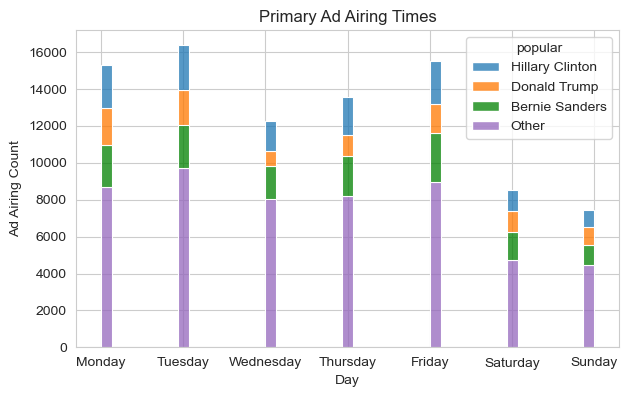

In [15]:
#For individual ones
days = ['Monday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
f = plt.figure(figsize= (7, 14))
gs = f.add_gridspec(3, 1)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[2, 0])
    sns.histplot(data = Primary, x = pd.DatetimeIndex(Primary['start_time']).weekday, hue = 'popular', hue_order=['Hillary Clinton', 'Donald Trump', 'Bernie Sanders', 'Other'], multiple = 'stack', palette = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), '#ff7800', 'green' , (0.5803921568627451, 0.403921568627451, 0.7411764705882353)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_xticklabels(days)
    ax.set_xlabel('Day')
    plt.title('Primary Ad Airing Times')


C:\Users\jpjon\AppData\Local\Temp\ipykernel_2064\674681129.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(days)
C:\Users\jpjon\AppData\Local\Temp\ipykernel_2064\674681129.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(days)
C:\Users\jpjon\AppData\Local\Temp\ipykernel_2064\674681129.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(days)


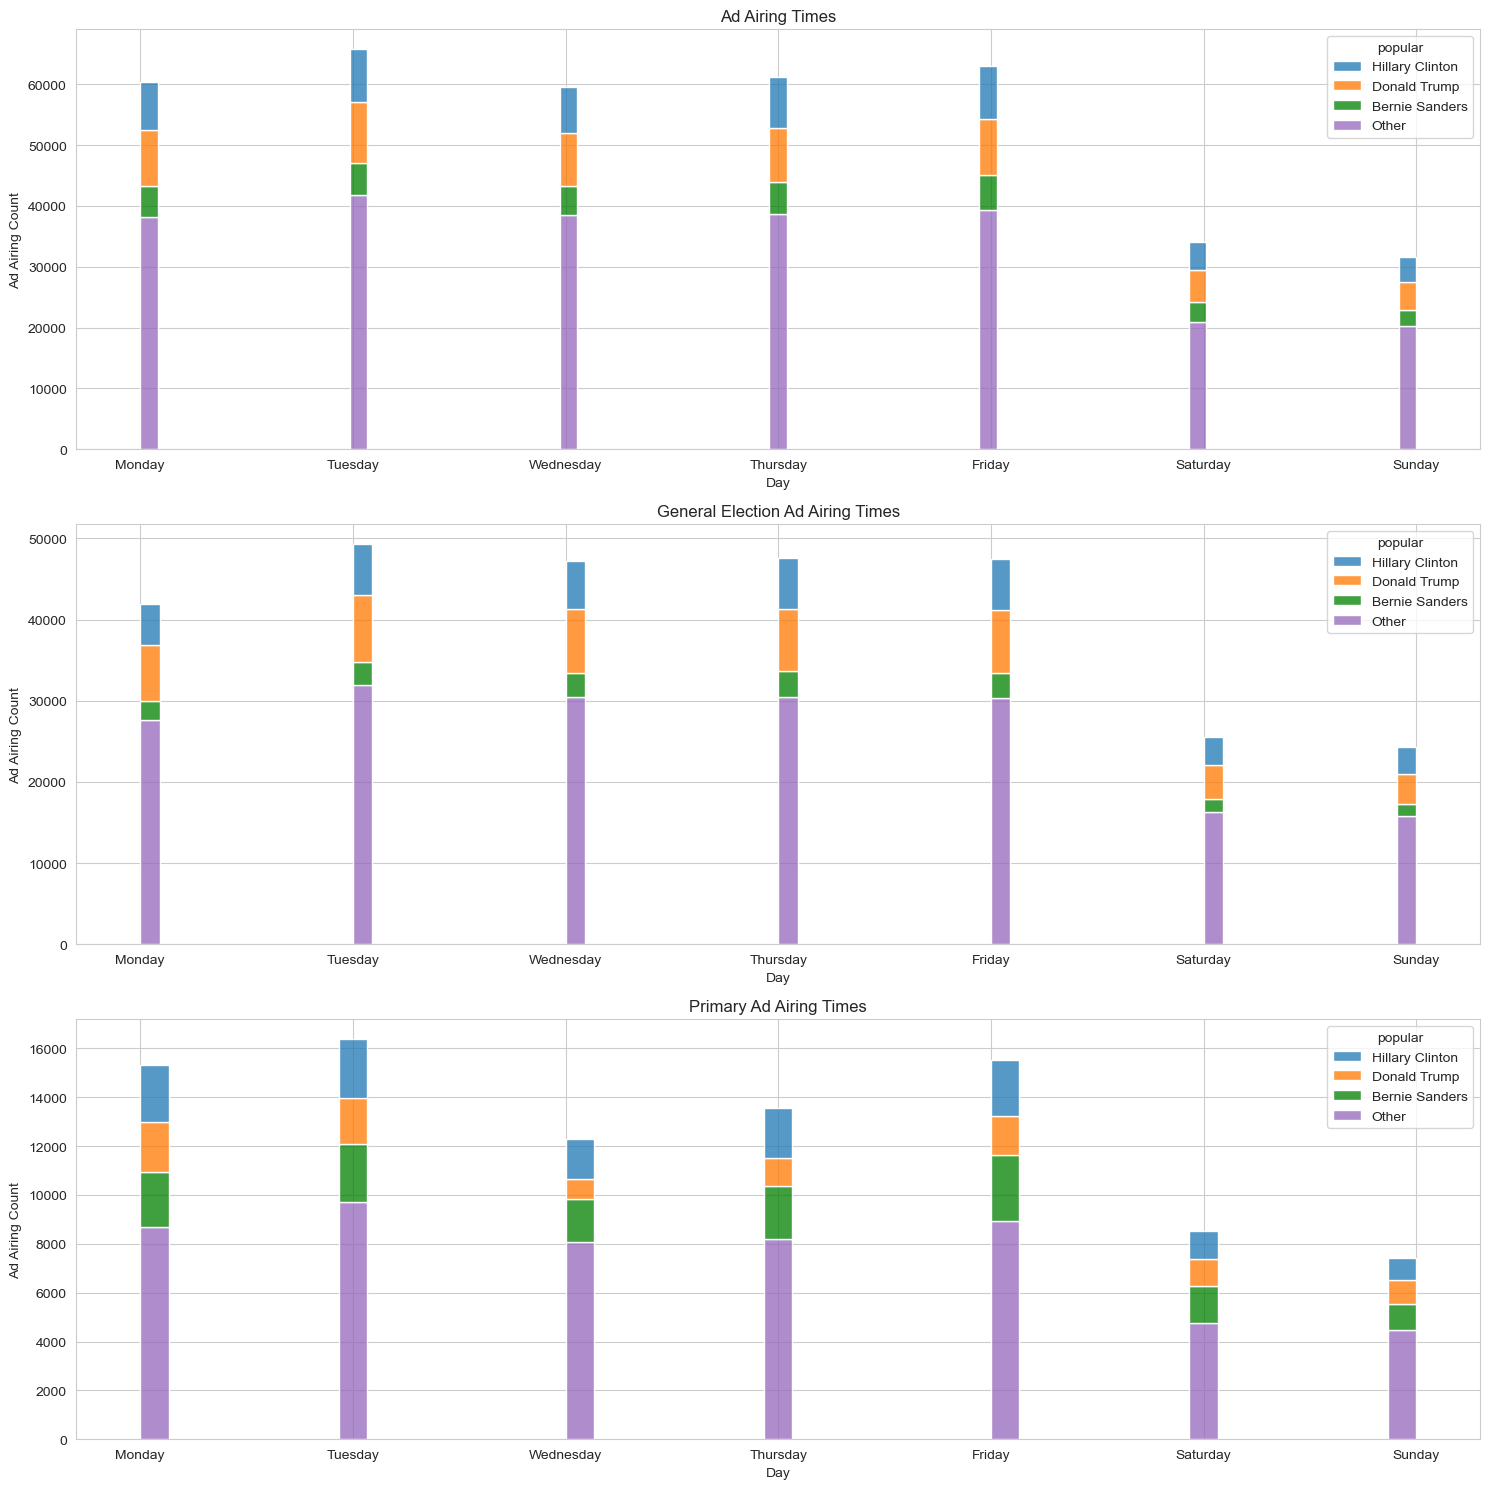

In [16]:
days = ['Monday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
f = plt.figure(figsize= (15, 15))
gs = f.add_gridspec(3, 1)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.histplot(data = data, x = pd.DatetimeIndex(data['start_time']).weekday, hue = 'popular', multiple = 'stack', hue_order=['Hillary Clinton', 'Donald Trump', 'Bernie Sanders', 'Other'], palette = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), '#ff7800', 'green' , (0.5803921568627451, 0.403921568627451, 0.7411764705882353)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_xlabel('Day')
    ax.set_xticklabels(days)
    plt.title('Ad Airing Times')

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.histplot(data = General, x = pd.DatetimeIndex(General['start_time']).weekday, hue = 'popular', hue_order=['Hillary Clinton', 'Donald Trump', 'Bernie Sanders', 'Other'], multiple = 'stack', palette = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), '#ff7800', 'green' , (0.5803921568627451, 0.403921568627451, 0.7411764705882353)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_xlabel('Day')
    ax.set_xticklabels(days)
    plt.title('General Election Ad Airing Times')

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[2, 0])
    sns.histplot(data = Primary, x = pd.DatetimeIndex(Primary['start_time']).weekday, hue = 'popular', hue_order=['Hillary Clinton', 'Donald Trump', 'Bernie Sanders', 'Other'], multiple = 'stack', palette = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), '#ff7800', 'green' , (0.5803921568627451, 0.403921568627451, 0.7411764705882353)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_xticklabels(days)
    ax.set_xlabel('Day')
    plt.title('Primary Ad Airing Times')

f.tight_layout()


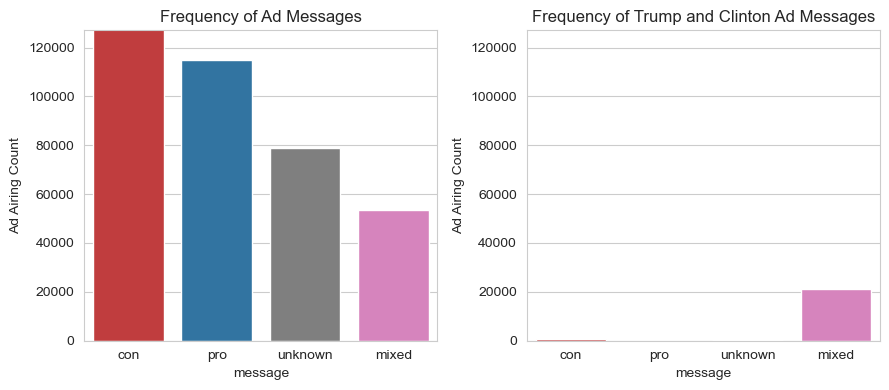

In [17]:
f = plt.figure(figsize= (9, 4))
gs = f.add_gridspec(1, 2)


with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.countplot(data = data, x = data['message'], order = data.message.value_counts().index, palette = [(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745) , (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_ylim(0, 127000)
    plt.title('Frequency of Ad Messages')

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.countplot(data=data, x=data[data['candidates'] == 'Donald Trump, Hillary Clinton']['message'], order = ['con', 'pro', 'unknown', 'mixed'],
                  palette=[(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                           (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                           (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
                           (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_ylim(0, 127000)
    plt.title('Frequency of Trump and Clinton Ad Messages')

plt.tight_layout()

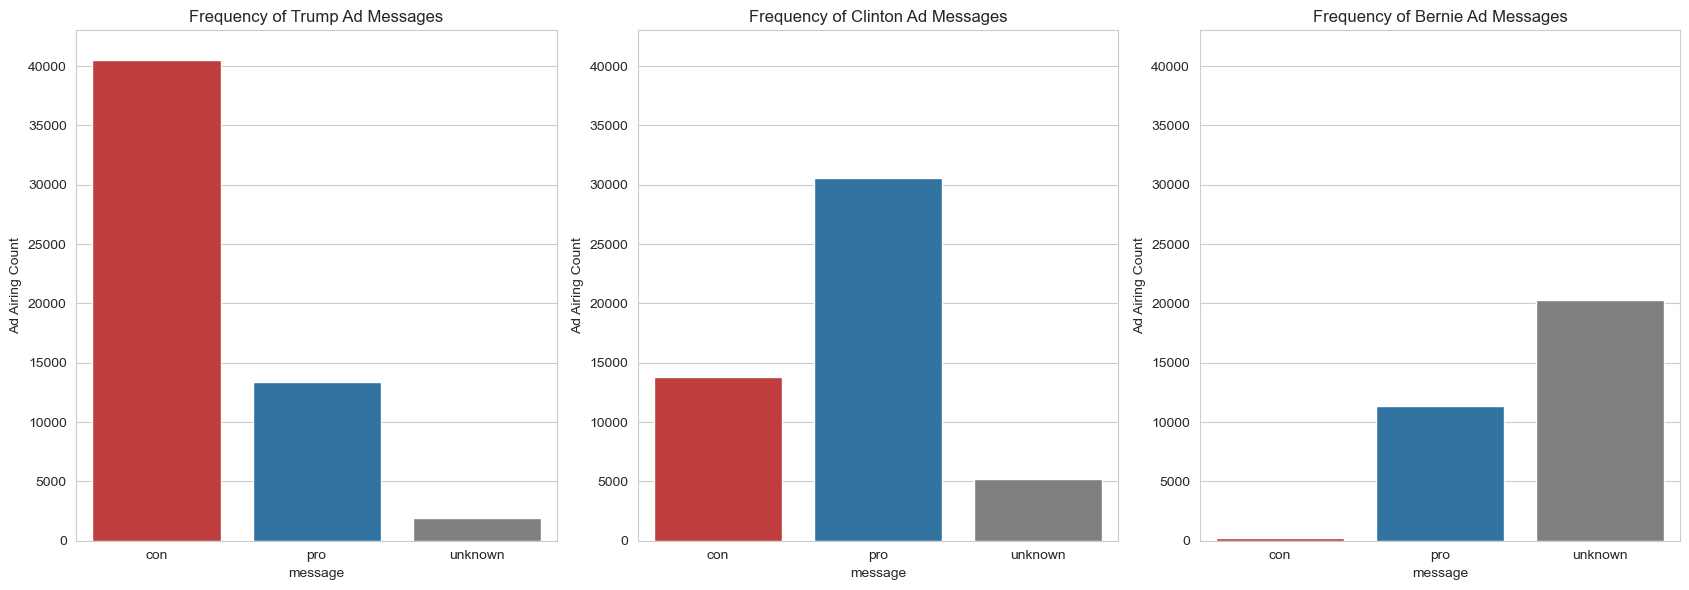

In [18]:
f = plt.figure(figsize=(17, 6))
gs = f.add_gridspec(1, 3)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.countplot(data=data, x=data[data['candidates'] == 'Donald Trump']['message'], order = ['con', 'pro', 'unknown'],
                  palette=[(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                           (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                           (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
                           (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_ylim(0, 43000)
    plt.title('Frequency of Trump Ad Messages')

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.countplot(data=data, x=data[data['candidates'] == 'Hillary Clinton']['message'], order = ['con', 'pro', 'unknown'],
                  palette=[(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                           (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                           (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
                           (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)])
    ax.set_ylabel('Count')
    plt.title('Frequency of Clinton Ad Messages')
    ax.set_ylim(0, 43000)
    ax.set_ylabel('Ad Airing Count')

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 2])
    sns.countplot(data=data, x=data[data['candidates'] == 'Bernie Sanders']['message'], order = ['con', 'pro', 'unknown'],
                  palette=[(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                           (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                           (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
                           (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_ylim(0, 43000)
    plt.title('Frequency of Bernie Ad Messages')

plt.tight_layout()

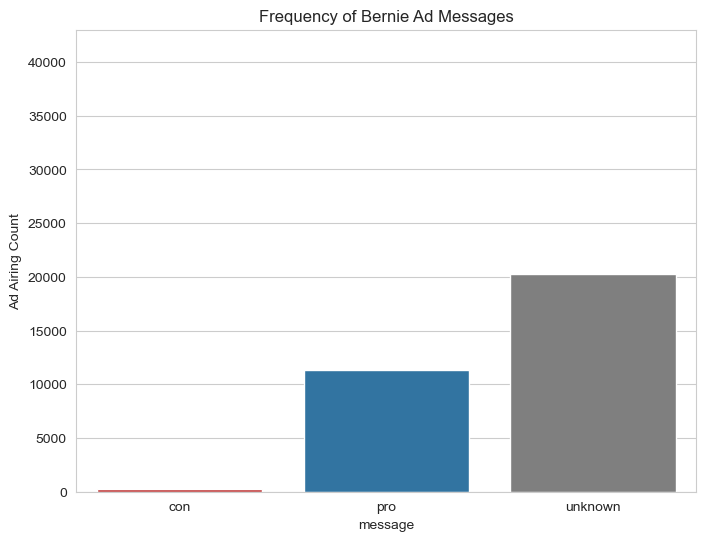

In [19]:
f = plt.figure(figsize=(8, 6))
gs = f.add_gridspec(1, 1)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.countplot(data=data, x=data[data['candidates'] == 'Bernie Sanders']['message'], order = ['con', 'pro', 'unknown'],
                  palette=[(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
                           (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
                           (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
                           (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)])
    ax.set_ylabel('Ad Airing Count')
    ax.set_ylim(0, 43000)
    plt.title('Frequency of Bernie Ad Messages')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


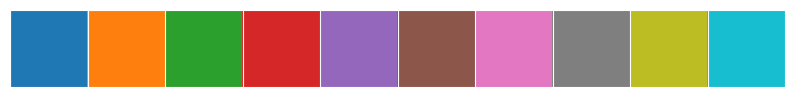

In [20]:
current_palette = sns.color_palette ()
sns.palplot(current_palette)
print(current_palette)

Let's go ahead and examine which candidate had the most ads and what type of ads they usually aired.

In [21]:
data[data['candidates'] == 'Donald Trump, Hillary Clinton']['sponsors'].value_counts()

Donald J. Trump For President           11086
Hillary for America                      8656
NRA Institute for Legislative Action      781
Stand For Truth                           390
Great America PAC                         282
Internet Archive                          188
Keep the Promise I                        146
Our Principles PAC                         95
Democratic National Cmte                   90
American Bridge 21st Century               89
Cruz for President                         62
iAmerica Action                            57
MoveOn.org                                 33
NextGen Climate Action                     18
Republicans for Clinton                     9
Reclaim America PAC                         8
American Crossroads                         4
Correct The Record                          3
Local Voices                                3
Club for Growth                             2
Free the Delegates                          2
Republican National Cmte          

In [73]:
#We can say that Donald Trump and Hillary Clinton ads are sponsored by Donald Trump more than Hillary Clinton.
print("Ads Featuring Both Trump and Hillary and The Messages Per Sponsor")
data[(data['candidates'] == 'Donald Trump, Hillary Clinton') & ((data['sponsors'] == 'Hillary for America') | (data['sponsors'] == 'Donald J. Trump For President'))].groupby(['candidates', 'message'])['sponsors'].value_counts()

Ads Featuring Both Trump and Hillary and The Messages Per Sponsor


candidates                     message  sponsors                     
Donald Trump, Hillary Clinton  mixed    Donald J. Trump For President    11086
                                        Hillary for America               8653
                               pro      Hillary for America                  3
Name: sponsors, dtype: int64

In [23]:
data.groupby(['start_time_day', 'candidates'])['air_count'].count()

start_time_day  candidates     
2014-09-01      none               1
2014-09-02      none               1
2014-09-06      none               1
2014-09-07      none               1
2014-09-12      none               1
                                  ..
2016-11-28      Donald Trump       1
                Hillary Clinton    4
                none               3
2016-11-29      Hillary Clinton    1
                none               2
Name: air_count, Length: 6278, dtype: int64

In [24]:
data.candidates.value_counts().index[:4]

Index(['Donald Trump', 'Hillary Clinton', 'Bernie Sanders',
       'Donald Trump, Hillary Clinton'],
      dtype='object')

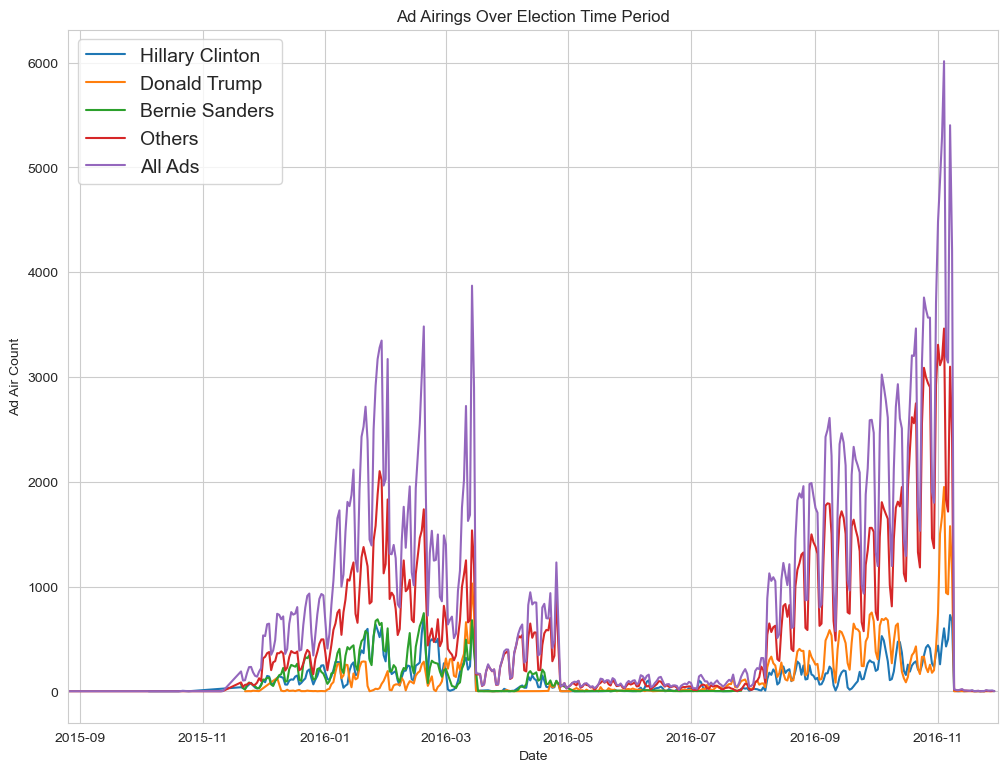

In [25]:
f = plt.figure(figsize= (12, 9))
gs = f.add_gridspec(1, 1)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    for candidate in list(data['popular'].unique()):
        sns.lineplot(data = data[data['candidates'] == candidate].groupby('start_time_day')['air_count'].count(), label = candidate)
    sns.lineplot(data = data[(data['candidates'] != "Donald Trump") & (data['candidates'] != 'Hillary Clinton') & (data.candidates != 'Bernie Sanders')].groupby('start_time_day')['air_count'].count(), label = 'Others')
    sns.lineplot(data = data.groupby('start_time_day')['air_count'].count(), label = "All Ads")
    #data.groupby('start_time_day')['air_count'].count().plot(kind = 'line')
    ax.set_ylabel('Count')
    ax.set_xlim([dt.date(2015, 8, 26), dt.date(2016, 12, 1)])
    ax.set_xlabel('Date')
    ax.set_ylabel('Ad Air Count')
    plt.title('Ad Airings Over Election Time Period')
    plt.legend(loc = 'upper left', prop = {'size' : 14})
#Explain what the period between 2016 and 2016-06 and why it ramps up at the end

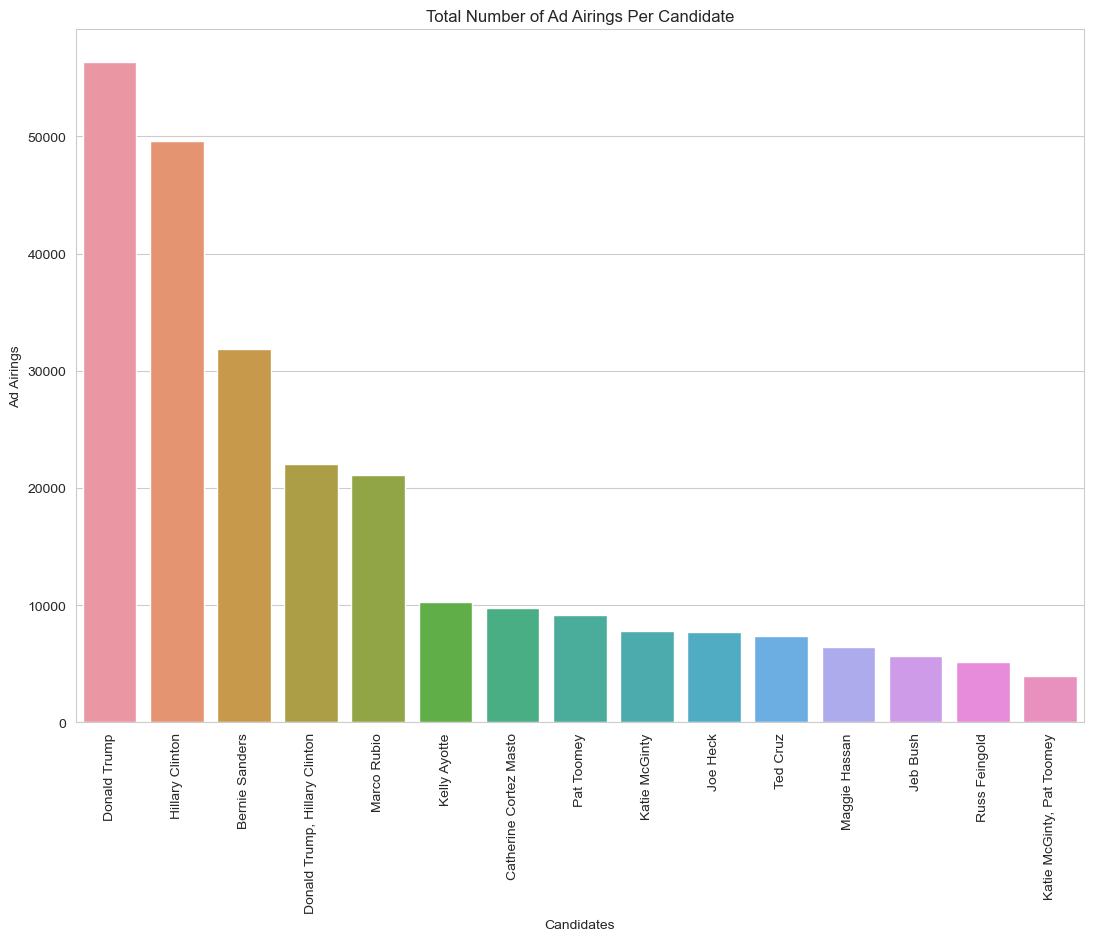

In [26]:
f = plt.figure(figsize= (13, 9))
gs = f.add_gridspec(1, 1)


with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.countplot(data = data, x = data['candidates'], order=data.candidates.value_counts().iloc[:15].index)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Ad Airings')
    ax.set_xlabel('Candidates')
    plt.title('Total Number of Ad Airings Per Candidate')


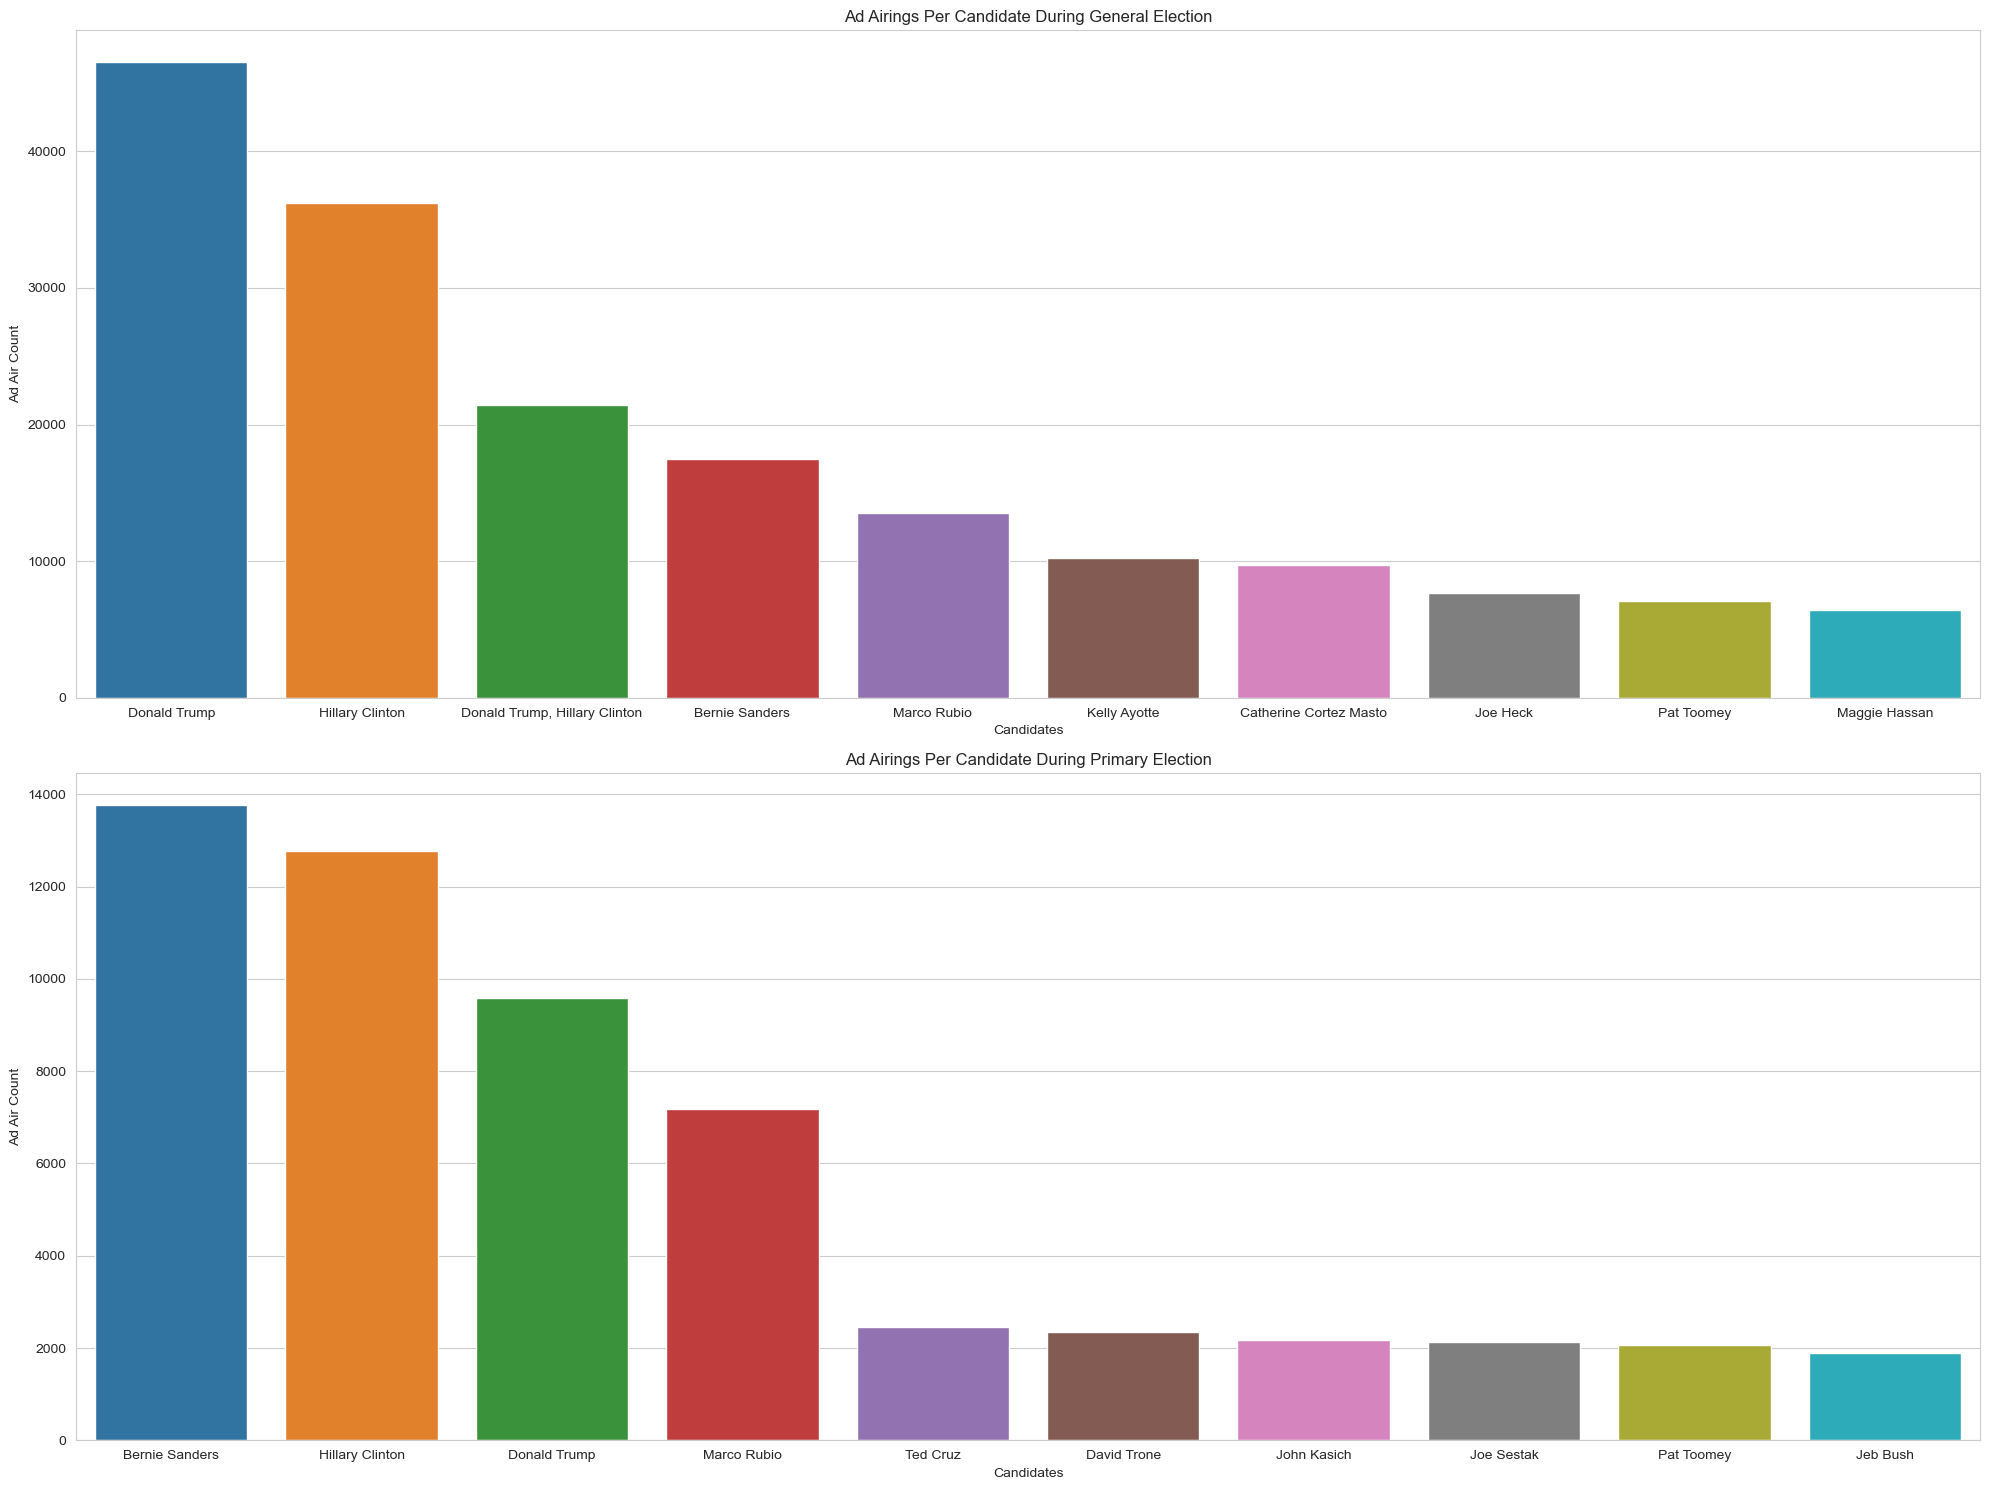

In [27]:
f = plt.figure(figsize= (20, 15))
gs = f.add_gridspec(2, 1)
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.countplot(data = General, x = General['candidates'], order=General.candidates.value_counts().iloc[:10].index)
    #General.candidates.value_counts()[:10].plot(kind = 'bar')
    ax.set_ylabel('Ad Air Count')
    ax.set_xlabel('Candidates')
    plt.title('Ad Airings Per Candidate During General Election')

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.countplot(data = Primary, x = Primary['candidates'], order=Primary.candidates.value_counts().iloc[:10].index)
    #Primary.candidates.value_counts()[:10].plot(kind = 'bar')
    ax.set_ylabel('Ad Air Count')
    ax.set_xlabel('Candidates')
    plt.title('Ad Airings Per Candidate During Primary Election')

f.tight_layout()

#Explain waht the period between 2016 and 2016-06 and why it ramps up at the end
#Do line chart with hue as candidate

In [28]:
data[data['candidates'] == 'Donald Trump'].sponsors.value_counts()

#Did Trump have more ads sponsored by Hillary for America than ads from his own sponsors?

Hillary for America                                   21265
Donald J. Trump For President                         12722
Priorities USA Action                                 11757
NextGen California Action Committee                    2606
Our Principles PAC                                     1935
American Future Fund                                   1313
Women Vote!                                            1084
Conservative Solutions PAC                             1033
Club for Growth                                         529
Club for Growth Action                                  501
MoveOn.org                                              337
Internet Archive                                        323
Correct The Record                                      187
Rebuilding America Now                                  137
Cruz for President                                      135
Keep the Promise I                                      134
Right to Rise USA                       

In [29]:
data[data['candidates'] == 'Hillary Clinton'].sponsors.value_counts()
data.groupby('candidates')['sponsors'].count().sort_values(ascending= False)

candidates
Donald Trump                                                              56297
Hillary Clinton                                                           49568
Bernie Sanders                                                            31886
Donald Trump, Hillary Clinton                                             22005
Marco Rubio                                                               21139
                                                                          ...  
Donald Trump, Gary Johnson, Gary Johnson, Hillary Clinton, Jill Stein         1
Donald Trump, Hillary Clinton, Jeb Bush, Marco Rubio, Ted Cruz, Carson        1
Carly Fiorina, Donald Trump, Hillary Clinton, Ted Cruz                        1
Hillary Clinton, John Kasich, Ted Cruz                                        1
Ben Carson, Donald Trump, Jeb Bush, Marco Rubio, Ted Cruz                     1
Name: sponsors, Length: 161, dtype: int64

In [30]:
data[data['candidates'] == 'Donald Trump, Hillary Clinton'].sponsors.value_counts()

#Were the majority of ads including Donald Trump and Hillary sponsored by Donald Trump?

Donald J. Trump For President           11086
Hillary for America                      8656
NRA Institute for Legislative Action      781
Stand For Truth                           390
Great America PAC                         282
Internet Archive                          188
Keep the Promise I                        146
Our Principles PAC                         95
Democratic National Cmte                   90
American Bridge 21st Century               89
Cruz for President                         62
iAmerica Action                            57
MoveOn.org                                 33
NextGen Climate Action                     18
Republicans for Clinton                     9
Reclaim America PAC                         8
American Crossroads                         4
Correct The Record                          3
Local Voices                                3
Club for Growth                             2
Free the Delegates                          2
Republican National Cmte          

In [66]:
print("Amount of Ads Sponsored by Hillary Towards Trump")
data[(data['candidates'] == 'Donald Trump') & (data['sponsors'] == 'Hillary for America')].message.value_counts()

Amount of Ads Sponsored by Hillary Towards Trump


con        20731
mixed        497
unknown       37
Name: message, dtype: int64

In [68]:
print("Amount of Ads Sponsored by Trump Towards Hillary")
data[(data['candidates'] == 'Hillary Clinton') & (data['sponsors'] == 'Donald J. Trump For President')].message.value_counts()

Amount of Ads Sponsored by Trump Towards Hillary


con    6670
Name: message, dtype: int64

In [ ]:
print("Amount of Ads Sponsored by Trump Towards Hillary")
data[(data['candidates'] == 'Hillary Clinton') & (data['sponsors'] == 'Donald J. Trump For President')].message.value_counts()

In [36]:
data['candidates'].value_counts()

Donald Trump                                                              56297
Hillary Clinton                                                           49568
Bernie Sanders                                                            31886
Donald Trump, Hillary Clinton                                             22005
Marco Rubio                                                               21139
                                                                          ...  
Donald Trump, Gary Johnson, Gary Johnson, Hillary Clinton, Jill Stein         1
Carly Fiorina, Donald Trump, Hillary Clinton, Ted Cruz                        1
Ben Carson, Donald Trump, Jeb Bush, Marco Rubio, Ted Cruz                     1
Hillary Clinton, John Kasich, Ted Cruz                                        1
Donald Trump, Hillary Clinton, Jeb Bush, Marco Rubio, Ted Cruz, Carson        1
Name: candidates, Length: 161, dtype: int64

In [37]:
data.head()

,wp_identifier,network,location,program,program_type,start_time,end_time,sponsors,sponsor_types,race,cycle,subjects,candidates,type,message,air_count,reference_count,market_count,start_time_day,popular
0,5643,KLAS,"Las Vegas, NV",8 News Now at 5 PM,news,2016-09-09 00:12:59,2016-09-09 00:13:29,Hillary for America,Multiple,PRES,2016.0,"Energy, China, Jobs",Hillary Clinton,campaign,pro,1916,0,6,2016-09-09,Hillary Clinton
1,5643,WNCN,"Raleigh-Durham-Fayetteville, NC",North Carolina News at 500PM,news,2016-09-06 21:58:25,2016-09-06 21:58:55,Hillary for America,Multiple,PRES,2016.0,"Energy, China, Jobs",Hillary Clinton,campaign,pro,1916,0,6,2016-09-06,Hillary Clinton
2,5643,KLAS,"Las Vegas, NV",Face the Nation,news,2016-09-04 16:24:25,2016-09-04 16:24:55,Hillary for America,Multiple,PRES,2016.0,"Energy, China, Jobs",Hillary Clinton,campaign,pro,1916,0,6,2016-09-04,Hillary Clinton
3,5643,WFLA,"Tampa-St. Petersburg, FL",Days of Our Lives,not news,2016-08-30 17:59:20,2016-08-30 17:59:50,Hillary for America,Multiple,PRES,2016.0,"Energy, China, Jobs",Hillary Clinton,campaign,pro,1916,0,6,2016-08-30,Hillary Clinton
4,5643,KSNV,"Las Vegas, NV",The Tonight Show Starring Jimmy Fallon,news,2016-09-06 07:02:22,2016-09-06 07:02:52,Hillary for America,Multiple,PRES,2016.0,"Energy, China, Jobs",Hillary Clinton,campaign,pro,1916,0,6,2016-09-06,Hillary Clinton


In [38]:
data.sponsors.value_counts()

Hillary for America              66219
Donald J. Trump For President    33170
Bernie 2016                      31562
Priorities USA Action            12691
Right to Rise USA                12069
                                 ...  
DNC Services Corp                    2
2016 Cmte                            1
Fenton Communications Inc            1
Carlos Beruff for Senate             1
Arizona Grassroots Action            1
Name: sponsors, Length: 204, dtype: int64

In [42]:
data1 = data[data['sponsors'].isin(list(data.sponsors.value_counts()[:7].index))]
data1['sponsors'].value_counts()
data.sponsors.value_counts()
data[data['candidates'] == 'Donald Trump']['sponsors'].value_counts()

Hillary for America                                   21265
Donald J. Trump For President                         12722
Priorities USA Action                                 11757
NextGen California Action Committee                    2606
Our Principles PAC                                     1935
American Future Fund                                   1313
Women Vote!                                            1084
Conservative Solutions PAC                             1033
Club for Growth                                         529
Club for Growth Action                                  501
MoveOn.org                                              337
Internet Archive                                        323
Correct The Record                                      187
Rebuilding America Now                                  137
Cruz for President                                      135
Keep the Promise I                                      134
Right to Rise USA                       

Text(222.3159722222222, 0.5, 'Sponsor')

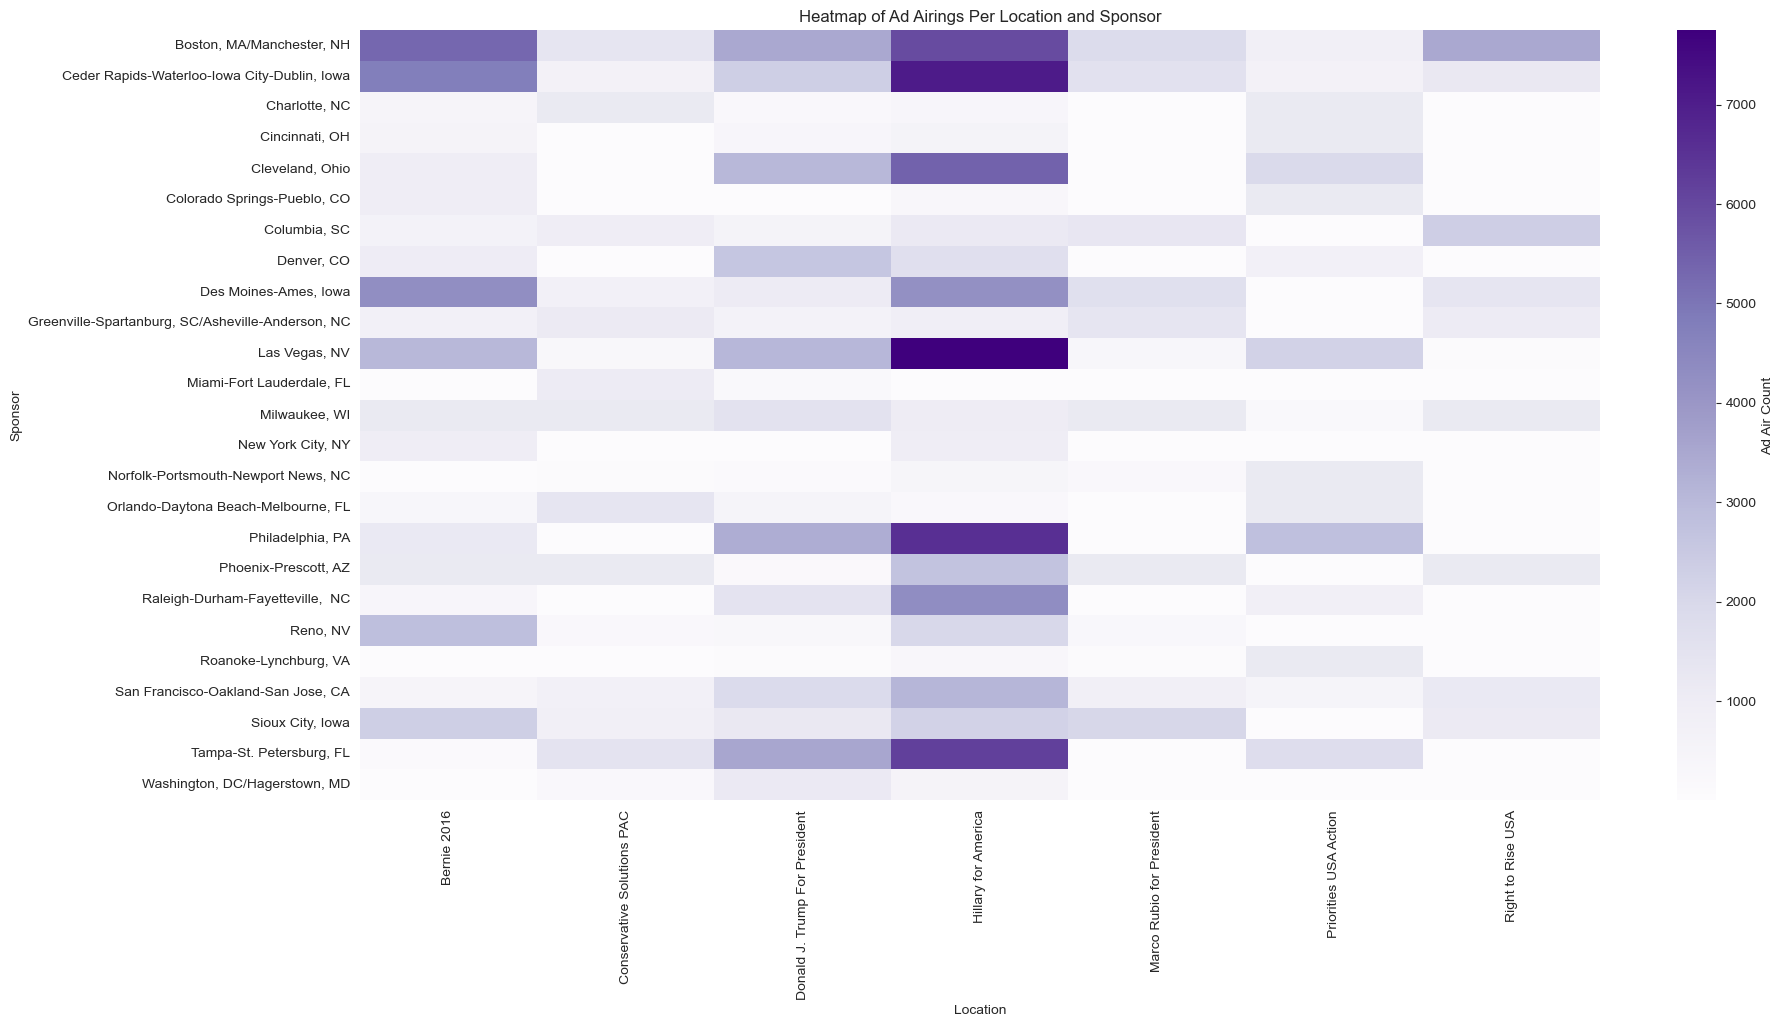

In [43]:
testing = data1.groupby(['sponsors', 'location']).agg({'air_count': 'count'})
testing_wide = testing.pivot_table(index = 'location', columns = 'sponsors', values = 'air_count')

fig, ax = plt.subplots(figsize=(20,10))

sns.heatmap(testing_wide, ax = ax, cmap = 'Purples', cbar_kws={'label': 'Ad Air Count'})
plt.title('Heatmap of Ad Airings Per Location and Sponsor')
ax.set_xlabel('Location')
ax.set_ylabel('Sponsor')


# How long did ads run for?

In [46]:
data['Ad_Length'] = data['end_time'] - data['start_time']

In [47]:
data.dtypes

wp_identifier                int64
network                     object
location                    object
program                     object
program_type                object
start_time          datetime64[ns]
end_time            datetime64[ns]
sponsors                    object
sponsor_types               object
race                        object
cycle                      float64
subjects                    object
candidates                  object
type                        object
message                     object
air_count                    int64
reference_count              int64
market_count                 int64
start_time_day      datetime64[ns]
popular                     object
Ad_Length          timedelta64[ns]
dtype: object

In [48]:
data['Ad_Length'] = data['Ad_Length'].dt.total_seconds()

In [49]:
data['Ad_Length'] = data.Ad_Length.astype(np.int64)

In [100]:
data['Ad_Length'].describe()[['mean', 'min', 'max']]

mean     32.490627
min      14.000000
max     300.000000
Name: Ad_Length, dtype: float64

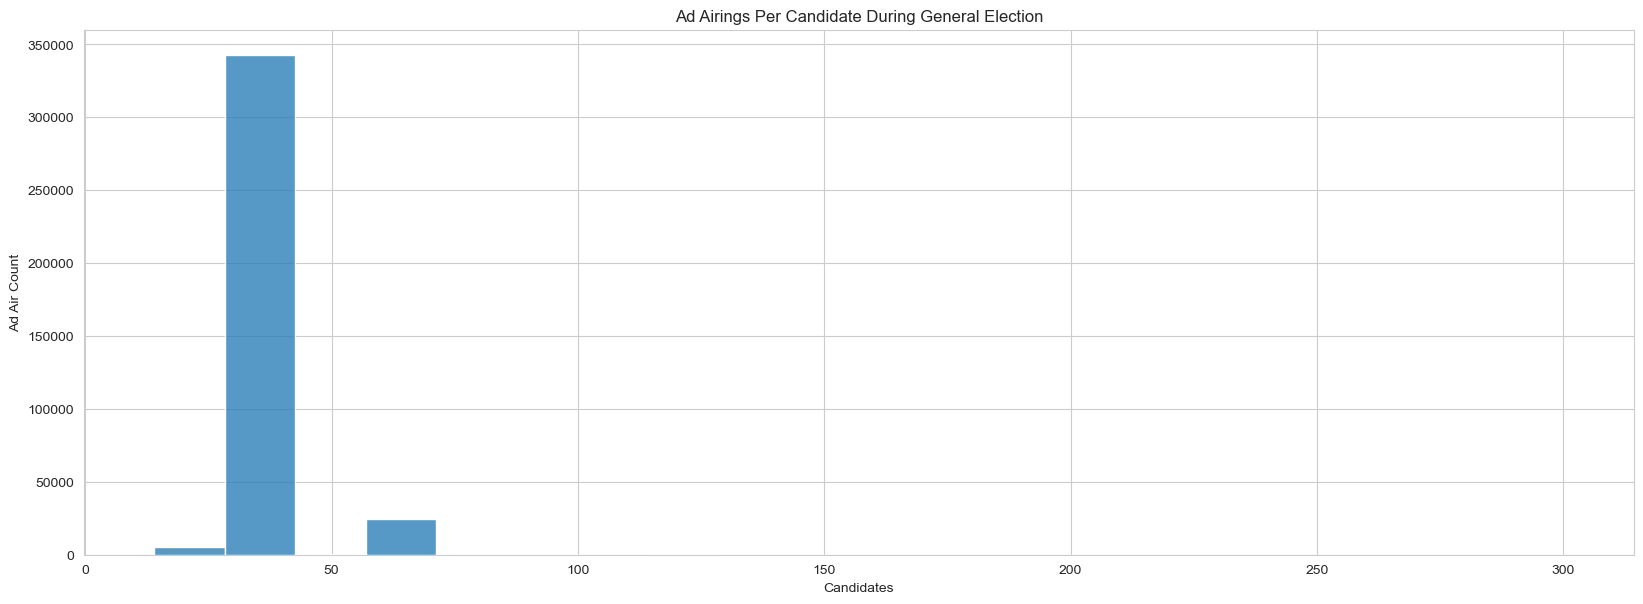

In [51]:
f = plt.figure(figsize= (20, 15))
gs = f.add_gridspec(2, 1)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.histplot(data = General, x = data['Ad_Length'])
    #General.candidates.value_counts()[:10].plot(kind = 'bar')
    ax.set_ylabel('Ad Air Count')
    ax.set_xlabel('Candidates')
    plt.title('Ad Airings Per Candidate During General Election')

In [60]:
data.loc[data['Ad_Length'].between(0, 30, 'left'), 'Seconds'] = '< 30 Seconds'
data.loc[data['Ad_Length'].between(30, 60, 'left'), 'Seconds'] = '30 - 60 Seconds'
data.loc[data['Ad_Length'].between(60, 300, 'both'), 'Seconds'] = '60 - 300 Seconds'

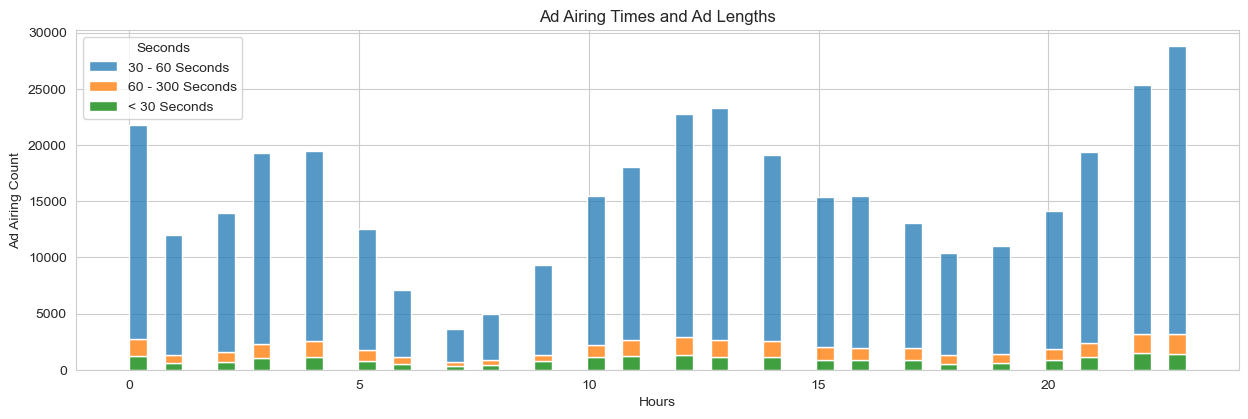

In [65]:
f = plt.figure(figsize= (15, 15))
gs = f.add_gridspec(3, 1)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.histplot(data = data, x = pd.DatetimeIndex(data['start_time']).hour, hue = 'Seconds',  multiple = 'stack', palette = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), '#ff7800', 'green' ])
    ax.set_ylabel('Ad Airing Count')
    ax.set_xlabel('Hours')
    plt.title('Ad Airing Times and Ad Lengths')

#How do i make this proportional??

# --------------------------------------------------